In [4]:
from tqdm import tqdm 
from sgp4.api import Satrec

from sgp4.api import Satrec
from sgp4.api import jday
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np
import math 
from astropy.coordinates import SkyCoord, TEME
from matplotlib.animation import FuncAnimation, ImageMagickFileWriter

import wand
from datetime import timedelta, datetime
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd
import requests


## 함수 선언

In [6]:
#dictionary방법
def read_tle(tle_list):
    i = 0
    
    val= {}
    
    while (i+1)*3 <= len(tle_list):
        sat_name = tle_list[i*3].strip(' \n')
        line1 = tle_list[i*3+1].strip('\n')
        line2 = tle_list[i*3+2].strip('\n')
        
        satellite = Satrec.twoline2rv(line1,line2)
        
        val[sat_name] = satellite
        
        i +=1
    
    return val
    
#list방법 r과 v를 저장
def read_tle_list(tle_list):
    i = 0
    jd, fr = 2458827, 0.362605 
    list1= []
    
    while (i+1)*3 <= len(tle_list):
        sat_name = tle_list[i*3].strip(' \n')
        line1 = tle_list[i*3+1].strip('\n')
        line2 = tle_list[i*3+2].strip('\n')

        
        satellite = Satrec.twoline2rv(line1,line2)
        e, r, v = satellite.sgp4(jd, fr)
        list1.append(r)
        list1.append(v)
        
        i +=1
    
    return list1

    
def make_jd(start_date, duration_time):
    jd_li, fr_li = [], []

    for i in range(duration_time):
        new_day = start_date + timedelta(seconds = i)

        yr, mon, day = new_day.year, new_day.month, new_day.day
        hour, min, sec = new_day.hour, new_day.minute, new_day.second
        
        jd, fr = jday(yr, mon, day, hour, min, sec)

        jd_li.append(jd)
        fr_li.append(fr)
        
    return np.array(jd_li), np.array(fr_li)

def orbit(satellite, jd_array, fr_array):

    e,r,v = satellite.sgp4_array(jd_array,fr_array)

    return r
def M(t):
    Mx = 0.002*math.sin(2*math.pi/300*t + 0.5*math.pi) + 0.01*math.cos(2*math.pi/200 * t + math.pi)
    My = 0.005*math.sin(2*math.pi/500*t + 1.5*math.pi) + 0.01*math.cos(2*math.pi/400 * t + 0.5*math.pi)
    Mz = 0.001*math.sin(2*math.pi/300*t) #양수의 토크를 주었더니 시계방향으로 회전(-축으로 회전)

    return np.array([[Mx],[My],[Mz]])
def f_v(t, w):
    trans_w = np.transpose(w)
    trans_h = np.transpose(I@w)
    res = np.cross(trans_w, trans_h)

    return I_inv@(M(t) - np.transpose(res))
def f_q(t, q, w):
    w1, w2, w3 = np.transpose(w)[0]
    omega = np.array([[0, w3, -w2, w1],
                      [-w3, 0, w1, w2],
                      [w2, -w1, 0, w3],
                      [-w1, -w2, -w3, 0]])
    
    return 1/2*omega@q
def e_t_q(li):
    a, b, c = li
    a, b, c = a/2, b/2, c/2

    return np.array([[math.sin(a)*math.cos(b)*math.cos(c) + math.cos(a)*math.sin(b)*math.sin(c)],
                     [-math.sin(a)*math.cos(b)*math.sin(c) + math.cos(a)*math.sin(b)*math.cos(c)],
                     [math.sin(a)*math.sin(b)*math.cos(c) + math.cos(a)*math.cos(b)*math.sin(c)],
                     [-math.sin(a)*math.sin(b)*math.sin(c) + math.cos(a)*math.cos(b)*math.cos(c)]])
def q_t_e(li):
    q1, q2, q3, q4 = li

    return np.array([[math.atan(4*(q2*q3+q1*q4)/(-(q1**2)-(q2**2)+(q3**2)+(q4**2)))],
                     [math.acos(-2*(q1*q3-q2*q4))],
                     [math.atan(4*(q1*q2+q3*q4)/((q1**2)-(q2**2)-(q3**2)+(q4**2)))]])
def q_t_d(li):
    q1, q2, q3, q4 = np.transpose(li)[0]

    return np.array([[(q4**2 + q1**2 -q2**2-q3**2), 2*(q1*q2+q3*q4), 2*(q1*q3-q2*q4)],
                     [2*(q1*q2-q3*q4), (q4**2-q1**2 + q2**2 - q3**2), 2*(q2*q3 + q1*q4)],
                     [2*(q1*q3+q2*q4), 2*(q2*q3 - q1*q4), (q4**2 - q1**2 - q2**2 + q3**2)]]) 

def rungekutha(t, w, q, h):
    k1 = h * f_v(t, w)
    k2 = h * f_v((t+h/2), (w + k1/2))
    k3 = h * f_v((t+h/2), (w + k2/2))
    k4 = h * f_v((t+h), (w + k3))
    
    new_w = w + (k1 + 2*k2 + 2*k3 + k4) / 6

    k1 = h * f_q(t, q, w)
    k2 = h * f_q((t+h/2), (q + k1/2), w)
    k3 = h * f_q((t+h/2), (q + k2/2), w)
    k4 = h * f_q((t+h), (q + k3), w)
    
    new_q = q + (k1 + 2*k2 + 2*k3 + k4) / 6

    return new_w, new_q

def unveal(li):
    new_li = []
    for i in li:
        new_li.append(i[0])
        

    return new_li
 
#list방법 으로 rv를 생성할 수 있는 객체를 저장.
def read_tle_sat(tle_list):
    i = 0
    jd, fr = 2458827, 0.362605 
    list1= []
    
    while (i+1)*3 <= len(tle_list):
        sat_name = tle_list[i*3].strip(' \n')
        line1 = tle_list[i*3+1].strip('\n')
        line2 = tle_list[i*3+2].strip('\n')

        
        satellite = Satrec.twoline2rv(line1,line2)
        

        list1.append(satellite)
        
        i +=1
    
    return list1

## TLE 데이터불러오기

In [8]:
# url = "https://celestrak.org/NORAD/elements/gp.php?INTDES=2023-083&FORMAT=tle"
url ="https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle"

r = requests.get(url)
TLE_data=r.text
TLE_split=TLE_data.split('\n')
my_TLE = [line.replace('\r', '') for line in TLE_split]


## 위성 1개의 궤도운동+자세

C:\Users\VDRC\AppData\Local\Temp\ipykernel_18532\614016368.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([[math.sin(a)*math.cos(b)*math.cos(c) + math.cos(a)*math.sin(b)*math.sin(c)],
C:\Users\VDRC\AppData\Local\Temp\ipykernel_18532\614016368.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [-math.sin(a)*math.cos(b)*math.sin(c) + math.cos(a)*math.sin(b)*math.cos(c)],
C:\Users\VDRC\AppData\Local\Temp\ipykernel_18532\614016368.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this

7431.942304982193


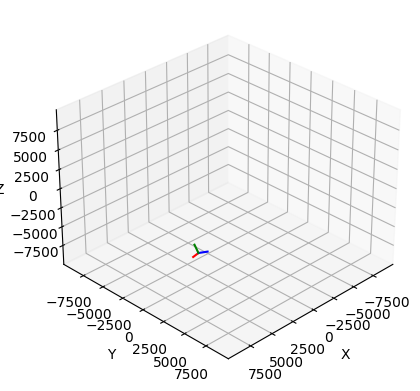

In [9]:
np.set_printoptions(precision=2)

sat_list=read_tle_sat(my_TLE) #데이터 정제하기

# target_sat = input('dic')
start_date = datetime(2019,12,1,0,0,0)
duration_time = 6000   #int(input('Second'))


I = np.array([[128.22, 0.26, -0.11],[0.26, 131.81, 0.74],[-0.11, 0.74, 71.93]])
I_inv = np.linalg.inv(I)
sat_path = [] # 위치저장
sat_new_path = [] # 좌표변환해서 위치저장.

t = 0
tend = duration_time
h = 0.1
time = [0]

jd, fr = make_jd(start_date, duration_time)

sat_path = orbit(sat_list[1], jd, fr) # 6000개 duration 만큼의 위치생성.
juliandate = [x+y for x, y in zip(jd, fr)]


for ele, juli in zip(sat_path,juliandate):
    xc, yc, zc = ele
    new_cord = SkyCoord(x = xc, y = yc, z = zc, frame = TEME(obstime = Time(juli,format = 'jd')), unit = 'kpc' , representation_type = 'cartesian').transform_to('icrs')
    new_cord.representation_type = 'cartesian'

    sat_new_path.append([new_cord.x.value, new_cord.y.value, new_cord.z.value])# 변환된 좌표계로 보내줌.


quaternion = [e_t_q(np.array([[math.pi*30/180],[0],[math.pi*20/180]]))]
anguler_velocity = [np.array([[math.pi*0.1/180],[0.0],[0.0]])]
dcm = [q_t_d(e_t_q(np.array([[math.pi*30/180],[0],[math.pi*20/180]])))]

#implementation

while time[-1] < tend:
    t = time[-1]
    w = anguler_velocity[-1]
    q = quaternion[-1]

    #print()

    new_w, new_q = rungekutha(t, w, q, h)
    q_norm = (new_q[0] ** 2 + new_q[1] ** 2 + new_q[2] ** 2 + new_q[3] ** 2)**(1/2)
    new_q = new_q/q_norm

    anguler_velocity.append(new_w)
    quaternion.append(new_q)
    dcm.append(q_t_d(new_q))
    time.append(t+h)


'''
Plot part  STARLINK-6209
'''


def animate(cord_cd):
    (x, y, z), dc = cord_cd

    location = np.array([x, y, z])
    location_matrix = np.transpose(np.array([location, location, location]))
    
    VecStart = np.array([[0,0,0],[0,0,0],[0,0,0]])
    j2k = np.array([[1,0,0],[0,1,0],[0,0,1]])
    
    VecEnd = np.transpose(dc) @ j2k
    VecEnd = VecEnd * bar_scale/8

    VecStart = VecStart + location_matrix #위성의 좌표축 시작.
    VecEnd = VecEnd + location_matrix # 위성의 좌표축 끝

    for i in range(3):
        line3d[i].set_data_3d([VecStart[0][i], VecEnd[0][i]], [VecStart[1][i],VecEnd[1][i]] , [VecStart[2][i],VecEnd[2][i]])

fig2 = plt.figure()
ax = fig2.add_subplot(projection='3d')

plot_path = sat_new_path[::100]#100번째만 찍어줌.
plot_dcm = dcm[:int(tend/h):int(1/h)*100] # [시작:끝:간격] [ :50000 : 1000 ]  50번
bar_scale = np.linalg.norm(max(plot_path))
factor = 1.3
print(bar_scale)


ax.set_xlim(-factor*bar_scale,factor*bar_scale)
ax.set_ylim(-factor*bar_scale,factor*bar_scale)
ax.set_zlim(-factor*bar_scale,factor*bar_scale)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(30,45)

line3d = []
col = ['red','blue','green']
for i in range(3):
    line3d.append(ax.plot([0, 0], [0, 0] ,zs = [0, 0], color = col[i])[0])

# point = ax.scatter(plot_path[0][0], plot_path[0][1], plot_path[0][2], color = 'black')
cord_dc = zip(plot_path, plot_dcm)

anim1 = FuncAnimation(fig2, animate, frames=cord_dc, interval = 10)

anim1.save('trajectory.gif', writer='imagemagick', fps=30, dpi=100)

# plt.show()
#2분30초 소요


### 두개 점 위치만 그리기

In [ ]:
np.set_printoptions(precision=2)
sat_list=read_tle_sat(my_TLE)

# target_sat = input('dic')
start_date = datetime(2019,12,1,0,0,0)#datetime.strptime(input('Date(seperate with -)', '%Y/%m/%d/%H/%M/%S'))
duration_time = 6000#int(input('Second'))


sat_path = [] # 위치저장
sat_new_path = [] # 좌표변환해서 위치저장.
sat_path1 = [] # 위치저장
sat_new_path1 = [] # 좌표변환해서 위치저장.

jd, fr = make_jd(start_date, duration_time)
sat_path = orbit(sat_list[0], jd, fr)
sat_path1 = orbit(sat_list[10], jd, fr) # 6000개 duration 만큼의 위치생성.
juliandate = [x+y for x, y in zip(jd, fr)]


for ele, juli in zip(sat_path,juliandate):
    xc, yc, zc = ele
    new_cord = SkyCoord(x = xc, y = yc, z = zc, frame = TEME(obstime = Time(juli,format = 'jd')), unit = 'kpc' , representation_type = 'cartesian').transform_to('icrs')
    new_cord.representation_type = 'cartesian'
    sat_new_path.append([new_cord.x.value, new_cord.y.value, new_cord.z.value])# 변환된 좌표계로 보내줌.\

for ele, juli in zip(sat_path1,juliandate):
    xc, yc, zc = ele
    new_cord = SkyCoord(x = xc, y = yc, z = zc, frame = TEME(obstime = Time(juli,format = 'jd')), unit = 'kpc' , representation_type = 'cartesian').transform_to('icrs')
    new_cord.representation_type = 'cartesian'
    sat_new_path1.append([new_cord.x.value, new_cord.y.value, new_cord.z.value])# 변환된 좌표계로 보내줌.
#5분걸림

In [ ]:
sat_new_path=sat_new_path
plot_path =sat_new_path
np_path=np.array(plot_path)

plot_path1 =sat_new_path1
np_path1=np.array(plot_path1)

len(np_path),len(np_path1)

(6000, 6000)

두개의 점 그리기

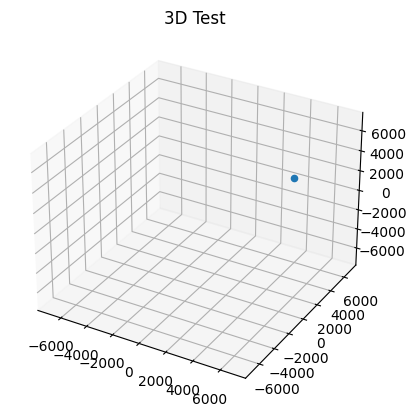

In [ ]:
a = np_path
b= np_path1
t = np.arange(0,len(a))

df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})
df1 = pd.DataFrame({"time": t ,"x" : b[:,0], "y" : b[:,1], "z" : b[:,2]})

def update_graph(num):

    data=df[df['time']==num]
    graph._offsets3d = (data.x, data.y, data.z)
    data1=df1[df1['time']==num]
    graph1._offsets3d = (data1.x, data1.y, data1.z)
    title.set_text('3D Test, time={}'.format(num))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')
ax.set_xlim(-7500, 7500)  # min_value_x와 max_value_x는 설정하고자 하는 범위 값
ax.set_ylim(-7500, 7500) # min_value_y와 max_value_y는 설정하고자 하는 범위 값
ax.set_zlim(-7500, 7500)  # min_value_z와 max_value_z는 설정하고자 하는 범위 값

data=df[df['time']==0]
data1=df1[df1['time']==0]
graph = ax.scatter(data.x, data.y, data.z)
graph1 = ax.scatter(data1.x, data1.y, data1.z)
plt.show()

In [ ]:

ani = FuncAnimation(fig, update_graph, 1000, interval=400, blit=False)
ani.save('trajectory2.gif', writer='imagemagick', fps=300, dpi=100)


MovieWriter imagemagick unavailable; using Pillow instead.


## 여러 점 그리기

In [11]:
# jd,fr 데이터 생성
np.set_printoptions(precision=2)
sat_list=read_tle_sat(my_TLE)

start_date = datetime(2019,12,1,0,0,0)
duration_time = 6000


jd, fr = make_jd(start_date, duration_time)
juliandate = [x+y for x, y in zip(jd, fr)]


In [12]:
sat_path=[]
for i in tqdm(range(len(sat_list))):
    sat_path.append( orbit(sat_list[i], jd, fr)[::100])

sat_new_path=[]
for j in tqdm(range(len(sat_path))):
    temp=[]
    for ele, juli in zip(sat_path[j],juliandate):
        xc, yc, zc = ele
        new_cord = SkyCoord(x = xc, y = yc, z = zc, frame = TEME(obstime = Time(juli,format = 'jd')), unit = 'kpc' , representation_type = 'cartesian').transform_to('icrs')
        new_cord.representation_type = 'cartesian'
        temp.append([new_cord.x.value, new_cord.y.value, new_cord.z.value])# 변환된 좌표계로 보내줌.\
    sat_new_path.append(temp)

  3%|▎         | 270/8805 [01:51<59:53,  2.37it/s]  c:\Users\VDRC\AppData\Local\Programs\Python\Python310\lib\site-packages\erfa\core.py:4613: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
c:\Users\VDRC\AppData\Local\Programs\Python\Python310\lib\site-packages\erfa\core.py:18999: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
100%|██████████| 8805/8805 [1:00:28<00:00,  2.43it/s]


In [13]:
sat_new_path=np.array(sat_new_path)
len(sat_new_path[1])

60

100%|██████████| 8805/8805 [00:37<00:00, 233.10it/s]


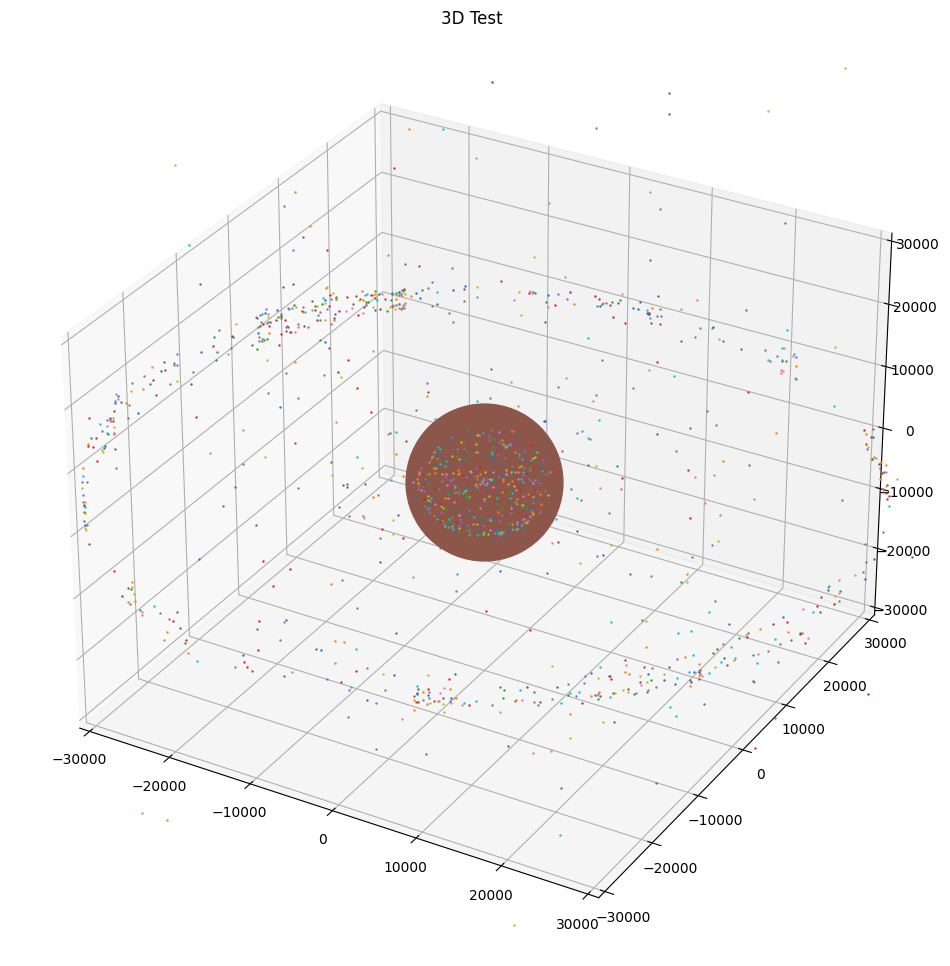

In [14]:
import pandas as pd
sat_new_path=sat_new_path
t = np.arange(0,len(sat_new_path[1]))
dfs = [pd.DataFrame({"time": t, "x": a[:, 0], "y": a[:, 1], "z": a[:, 2]}) for a in sat_new_path]
df=pd.DataFrame({"time": t, "x": 0, "y": 0, "z": 0})

def update_graph1(num):
    for j in range(len(dfs)):
        data=dfs[j][dfs[j]['time']==num]
        graph_T[j]._offsets3d = (data.x, data.y, data.z)
    data1=df[df['time']==num]
    graph1._offsets3d = (data1.x, data1.y, data1.z)
           
    title.set_text('3D Test, time={}'.format(num))

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')
ax.set_xlim(-30000, 30000)  # min_value_x와 max_value_x는 설정하고자 하는 범위 값
ax.set_ylim(-30000, 30000) # min_value_y와 max_value_y는 설정하고자 하는 범위 값
ax.set_zlim(-30000, 30000)  # min_value_z와 max_value_z는 설정하고자 하는 범위 값
graph_T=[]
for i in tqdm(range(len(dfs))):
    data=dfs[i][dfs[i]['time']==0]
    graph = ax.scatter(data.x, data.y, data.z,s=0.5)
    graph_T.append(graph)
data1=df[df['time']==0]   
graph1= ax.scatter(data1.x, data1.y, data1.z,s=(6378.1)*2)

plt.show()

In [ ]:
#20개 8분.
#1000개 5point : 1분30초
#1000개 20point : 5분
ani = FuncAnimation(fig, update_graph1, 6000, interval=400, blit=False)
ani.save('trajectory_total3.gif', writer='imagemagick', fps=200, dpi=100)


## Cesium - czml

In [ ]:
import pyvista as pv
import math
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm
earth_radius = 6378.1

sphere = pv.Sphere(radius=earth_radius, theta_resolution=240, phi_resolution=240, start_theta=270.0001, end_theta=270)
sphere.active_t_coords = np.zeros((sphere.points.shape[0], 2))

for i in range(sphere.points.shape[0]):
    x, y, z = sphere.points[i, 0]/earth_radius, sphere.points[i, 1]/earth_radius, sphere.points[i, 2]/earth_radius
    x, y, z = normalize(x), normalize(y), normalize(z)
     
    sphere.active_t_coords[i] = [0.5 + math.atan2(-x, y)/(2 * math.pi), 0.5 + math.asin(z)/math.pi]

sphere.rotate_z(-90)

# load satellite

pl = pv.Plotter()
pl.add_background_image('starry-night-sky-fit.jpg', scale=1.001)
pl.add_mesh(sphere, texture=pv.read_texture("earth.jpg"), smooth_shading=False)
pl.show()

